## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.
> If it's exactly in between two options, select the higher value.

In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-11-26 21:32:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-11-26 21:32:23 (7.30 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [33]:
import pandas as pd
import numpy as np
df = pd.read_csv('course_lead_scoring.csv')

In [34]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [35]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [36]:
cat_col = ['lead_source','industry','employment_status','location']
num_col = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']
y = df['converted']
del df['converted']
df[cat_col] = df[cat_col].fillna('NA')
df[num_col] = df[num_col].fillna('0')

In [37]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

df_full_train,df_test,y_full_train,y_test = train_test_split(df,y,test_size=0.20, random_state=1)
df_train,df_val,y_train,y_val = train_test_split(df_full_train,y_full_train,test_size=0.25, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [39]:
from sklearn.metrics import roc_auc_score

for col in num_col:
    roc =  roc_auc_score(y_train,df_train[col])
    print(f"ROC score for {col} is :{roc}")

ROC score for number_of_courses_viewed is :0.7635680590007088
ROC score for annual_income is :0.5519578313253012
ROC score for interaction_count is :0.738270176293409
ROC score for lead_score is :0.6144993577250176


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve,roc_auc_score

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)
    ],
    remainder='passthrough'   # keep numerical columns
)

model = Pipeline(steps=[
    ('preprocessor', preprocess),
    ('logreg', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

model.fit(df_train,y_train)
y_pred = model.predict_proba(df_val)[:, 1]
score = roc_auc_score(y_val,y_pred)
print(round(score,3))

0.817


In [42]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


roc_auc_score(y_val, y_pred)



/home/nastavirs/ML-Zoomcamp/.myvenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8171316268814112

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

/home/nastavirs/ML-Zoomcamp/.myvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nastavirs/ML-Zoomcamp/.myvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/nastavirs/ML-Zoomcamp/.myvenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

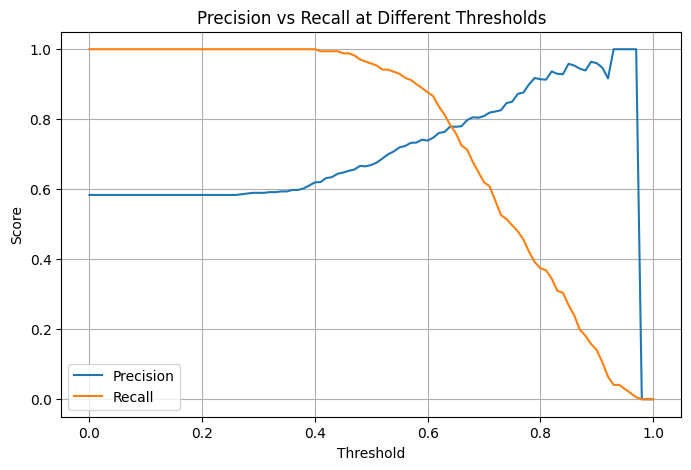

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

y_prob = model.predict_proba(df_val)[:, 1]
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall at Different Thresholds")
plt.legend()
plt.grid(True)
plt.show()


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [24]:
f1score = []

for i in range(len(thresholds)):
    p = precisions[i]
    r = recalls[i]
    
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * (p * r) / (p + r)
    
    f1score.append(f1)
    #print(f"Threshold {thresholds[i]:.2f} → F1 = {f1:.3f}")

best_idx = np.argmax(f1score)
print("Best F1 threshold:", thresholds[best_idx])
print("Best F1 score:", f1score[best_idx])



Best F1 threshold: 0.5700000000000001
Best F1 score: 0.8124999999999999


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [28]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(
    model, 
    df_full_train, 
    y_full_train, 
    cv=kf,
    scoring='roc_auc'
)

print("ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())
print("Std ROC-AUC:",scores.std())


ROC-AUC scores: [0.80607459 0.87137384 0.77543201 0.80183686 0.85582727]
Mean ROC-AUC: 0.8221089148573075
Std ROC-AUC: 0.03580711942905165



### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

## Submit the results



In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

preprocess = ColumnTransformer(
    transformers=[('cat',OneHotEncoder(handle_unknown='ignore'),cat_col)]
,remainder='passthrough')


from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np

C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for C in C_values:
    # rebuild pipeline with new C
    model = Pipeline(steps=[
        ('preprocessor', preprocess),
        ('logreg', LogisticRegression(
            solver='liblinear',
            C=C,
            max_iter=1000
        ))
    ])

    # cross-validate
    scores = cross_val_score(
        model,
        df_train,
        y_train,
        cv=kf,
        scoring='roc_auc'
    )

    print(f"C={C} → AUC scores: {np.round(scores, 3)} | Mean AUC = {scores.mean():.3f} | Std AUC = {scores.std():.3f} ")


C=1e-06 → AUC scores: [0.527 0.542 0.553 0.578 0.59 ] | Mean AUC = 0.558 | Std AUC = 0.023 
C=0.001 → AUC scores: [0.898 0.883 0.859 0.885 0.844] | Mean AUC = 0.874 | Std AUC = 0.019 
C=1 → AUC scores: [0.841 0.854 0.804 0.86  0.803] | Mean AUC = 0.833 | Std AUC = 0.024 
